# Mountain Car with Linear Function Approximation

In [1]:
using ReinforcementLearningBase, ReinforcementLearningEnvironments
using Plots; gr(); 
import StatsBase.sample
env = MountainCarEnv();

Firstly, we will define tillings:

In [2]:
tilling(S,n,offset) = [(i,j) for i in range(S[1].left + offset,S[1].right + offset, length = n + 1), 
        j in range(S[2].left + offset,S[2].right + offset, length = n + 1)] 

tillings(S,n,m) = [tilling(S,n,i/n) for i = 0:m-1]

between(x,a,b) = a ≤ x < b 

code(s,t::Array{Tuple{Float64,Float64},2}) = [between(s[1],t[i,j][1],t[i+1,j][1]) && between(s[2],t[i,j][2],t[i,j+1][2])
      for j = 1:size(t,2)-1 for i = 1:size(t,1)-1]

code(s,tillings::Array{Array{Tuple{Float64,Float64},2},1}) = 
                vcat([code(s,t) for t in tillings]...)


code (generic function with 2 methods)

Then Agent:

In [3]:
mutable struct Agent
    env::AbstractEnv
    ϵ::Float64
    ϵ_decay::Float64
    ϵ_min::Float64
    β::Float64
    η::Float64
    tillings::Array{Array{Tuple{Float64,Float64},2},1}
    W::Array{Float64,2}
    position::Float64
    reward::Float64
end

Agent(env, n, m, ϵ = 1.0, ϵ_decay = 0.9975, 
    ϵ_min = 0.005, β = 0.99, η = 0.02) = Agent(env, ϵ, ϵ_decay, ϵ_min, β, η,
                                                tillings(state_space(env), n, m),
                                                rand(length(action_space(env)), n*n*m),
                                                -Inf, 0.0)

Agent

Finally, functions that control the learning process:

In [4]:
policy(agent::Agent, state::Array{Bool,1}) = argmax(agent.W * state)

policy (generic function with 1 method)

In [5]:
function step!(agent::Agent, train::Bool)
    s = code(deepcopy(state(agent.env)), agent.tillings)
    (rand() < agent.ϵ  && train) ? (a = rand(agent.env.action_space)) : (a = policy(agent, s))
    agent.env(a)
    r, s′, terminal = deepcopy(reward(agent.env)), deepcopy(state(agent.env)), deepcopy(is_terminated(agent.env))
    agent.position = s′[1]
    s′ = code(s′,agent.tillings)
    agent.reward += r
    if train
        if terminal
            R  = r
        else
            Q_new_state = agent.W * s′
            rand() < agent.ϵ ?  R = r + agent.β * rand(Q_new_state) :
            R = r + agent.β * Q_new_state[policy(agent,s′)]
        end
        Q_hat = agent.W * s
        Q = deepcopy(Q_hat)
        Q[a] = R
        agent.W += agent.η*(Q .- Q_hat) * transpose(s)
    end
    terminal 
end

step! (generic function with 1 method)

In [6]:
function run!(agent::Agent, episodes::Int; train::Bool = true, plotting::Bool = true, summary::Bool = true)
    rewards = []
    success_rates = []
    ep = 1.0
    success = 0.0
    while ep ≤ episodes
        plotting && (plot(agent.env); sleep(0.0001))
        if step!(agent, train) 
            reset!(agent.env)
            agent.position > 0.5 && (success += 1.0)
            push!(rewards, agent.reward)
            push!(success_rates, success/ep)
            if summary
                println("episode $(Int(ep)) ends! Reward: $(agent.reward)")
                println("ϵ: $(agent.ϵ), success rate: $(success/ep)")
            end
            ep += 1.0
            agent.reward = 0.0
            agent.position = -Inf
            eps = agent.ϵ * agent.ϵ_decay
            agent.ϵ = max(agent.ϵ_min, eps)
        end
    end
    return rewards, success_rates
end

run! (generic function with 1 method)

## Experiment

In [7]:
agent = Agent(env,8,4);

Before Learning:

In [8]:
#rewards,_ = run!(agent,10; train = false, plotting = true);

After Learning:

In [9]:
rewards, success_rates = run!(agent,5_000; plotting = false);
#rewards,_ = run!(agent,10; train = false, plotting = true);

episode 1 ends! Reward: -199.0
ϵ: 1.0, success rate: 0.0
episode 2 ends! Reward: -199.0
ϵ: 0.9975, success rate: 0.0
episode 3 ends! Reward: -199.0
ϵ: 0.9950062500000001, success rate: 0.0
episode 4 ends! Reward: -199.0
ϵ: 0.9925187343750002, success rate: 0.0
episode 5 ends! Reward: -199.0
ϵ: 0.9900374375390627, success rate: 0.0
episode 6 ends! Reward: -199.0
ϵ: 0.9875623439452151, success rate: 0.0
episode 7 ends! Reward: -199.0
ϵ: 0.9850934380853521, success rate: 0.0
episode 8 ends! Reward: -199.0
ϵ: 0.9826307044901388, success rate: 0.0
episode 9 ends! Reward: -199.0
ϵ: 0.9801741277289134, success rate: 0.0
episode 10 ends! Reward: -199.0
ϵ: 0.9777236924095912, success rate: 0.0
episode 11 ends! Reward: -199.0
ϵ: 0.9752793831785673, success rate: 0.0
episode 12 ends! Reward: -199.0
ϵ: 0.972841184720621, success rate: 0.0
episode 13 ends! Reward: -199.0
ϵ: 0.9704090817588195, success rate: 0.0
episode 14 ends! Reward: -199.0
ϵ: 0.9679830590544225, success rate: 0.0
episode 15 ends

ϵ: 0.7186267435638969, success rate: 0.0
episode 134 ends! Reward: -199.0
ϵ: 0.7168301767049872, success rate: 0.0
episode 135 ends! Reward: -199.0
ϵ: 0.7150381012632248, success rate: 0.0
episode 136 ends! Reward: -199.0
ϵ: 0.7132505060100668, success rate: 0.0
episode 137 ends! Reward: -199.0
ϵ: 0.7114673797450417, success rate: 0.0
episode 138 ends! Reward: -199.0
ϵ: 0.7096887112956791, success rate: 0.0
episode 139 ends! Reward: -199.0
ϵ: 0.70791448951744, success rate: 0.0
episode 140 ends! Reward: -199.0
ϵ: 0.7061447032936464, success rate: 0.0
episode 141 ends! Reward: -199.0
ϵ: 0.7043793415354124, success rate: 0.0
episode 142 ends! Reward: -199.0
ϵ: 0.7026183931815739, success rate: 0.0
episode 143 ends! Reward: -199.0
ϵ: 0.70086184719862, success rate: 0.0
episode 144 ends! Reward: -199.0
ϵ: 0.6991096925806235, success rate: 0.0
episode 145 ends! Reward: -199.0
ϵ: 0.6973619183491719, success rate: 0.0
episode 146 ends! Reward: -199.0
ϵ: 0.6956185135532991, success rate: 0.0
e

ϵ: 0.5112794862581179, success rate: 0.0
episode 270 ends! Reward: -199.0
ϵ: 0.5100012875424726, success rate: 0.0
episode 271 ends! Reward: -199.0
ϵ: 0.5087262843236164, success rate: 0.0
episode 272 ends! Reward: -199.0
ϵ: 0.5074544686128074, success rate: 0.0
episode 273 ends! Reward: -199.0
ϵ: 0.5061858324412755, success rate: 0.0
episode 274 ends! Reward: -199.0
ϵ: 0.5049203678601722, success rate: 0.0
episode 275 ends! Reward: -199.0
ϵ: 0.5036580669405218, success rate: 0.0
episode 276 ends! Reward: -199.0
ϵ: 0.5023989217731706, success rate: 0.0
episode 277 ends! Reward: -199.0
ϵ: 0.5011429244687376, success rate: 0.0
episode 278 ends! Reward: -199.0
ϵ: 0.49989006715756584, success rate: 0.0
episode 279 ends! Reward: -199.0
ϵ: 0.49864034198967194, success rate: 0.0
episode 280 ends! Reward: -199.0
ϵ: 0.4973937411346978, success rate: 0.0
episode 281 ends! Reward: -199.0
ϵ: 0.4961502567818611, success rate: 0.0
episode 282 ends! Reward: -199.0
ϵ: 0.49490988113990647, success rate

ϵ: 0.3655843130688413, success rate: 0.0
episode 404 ends! Reward: -199.0
ϵ: 0.36467035228616923, success rate: 0.0
episode 405 ends! Reward: -199.0
ϵ: 0.36375867640545384, success rate: 0.0
episode 406 ends! Reward: -199.0
ϵ: 0.3628492797144402, success rate: 0.0
episode 407 ends! Reward: -199.0
ϵ: 0.3619421565151541, success rate: 0.0
episode 408 ends! Reward: -199.0
ϵ: 0.3610373011238662, success rate: 0.0
episode 409 ends! Reward: -199.0
ϵ: 0.36013470787105656, success rate: 0.0
episode 410 ends! Reward: -199.0
ϵ: 0.35923437110137896, success rate: 0.0
episode 411 ends! Reward: -199.0
ϵ: 0.35833628517362554, success rate: 0.0
episode 412 ends! Reward: -199.0
ϵ: 0.3574404444606915, success rate: 0.0
episode 413 ends! Reward: -199.0
ϵ: 0.3565468433495398, success rate: 0.0
episode 414 ends! Reward: -199.0
ϵ: 0.35565547624116595, success rate: 0.0
episode 415 ends! Reward: -199.0
ϵ: 0.354766337550563, success rate: 0.0
episode 416 ends! Reward: -199.0
ϵ: 0.3538794217066866, success ra

ϵ: 0.26271866439870534, success rate: 0.0
episode 536 ends! Reward: -199.0
ϵ: 0.26206186773770856, success rate: 0.0
episode 537 ends! Reward: -199.0
ϵ: 0.2614067130683643, success rate: 0.0
episode 538 ends! Reward: -199.0
ϵ: 0.26075319628569343, success rate: 0.0
episode 539 ends! Reward: -199.0
ϵ: 0.2601013132949792, success rate: 0.0
episode 540 ends! Reward: -199.0
ϵ: 0.2594510600117418, success rate: 0.0
episode 541 ends! Reward: -199.0
ϵ: 0.25880243236171246, success rate: 0.0
episode 542 ends! Reward: -199.0
ϵ: 0.2581554262808082, success rate: 0.0
episode 543 ends! Reward: -199.0
ϵ: 0.25751003771510617, success rate: 0.0
episode 544 ends! Reward: -199.0
ϵ: 0.2568662626208184, success rate: 0.0
episode 545 ends! Reward: -199.0
ϵ: 0.2562240969642664, success rate: 0.0
episode 546 ends! Reward: -199.0
ϵ: 0.25558353672185574, success rate: 0.0
episode 547 ends! Reward: -199.0
ϵ: 0.2549445778800511, success rate: 0.0
episode 548 ends! Reward: -199.0
ϵ: 0.254307216435351, success ra

episode 641 ends! Reward: -199.0
ϵ: 0.20149245557815434, success rate: 0.0046801872074883
episode 642 ends! Reward: -199.0
ϵ: 0.20098872443920898, success rate: 0.004672897196261682
episode 643 ends! Reward: -199.0
ϵ: 0.20048625262811098, success rate: 0.004665629860031105
episode 644 ends! Reward: -199.0
ϵ: 0.19998503699654072, success rate: 0.004658385093167702
episode 645 ends! Reward: -199.0
ϵ: 0.19948507440404936, success rate: 0.004651162790697674
episode 646 ends! Reward: -199.0
ϵ: 0.19898636171803924, success rate: 0.0046439628482972135
episode 647 ends! Reward: -199.0
ϵ: 0.19848889581374415, success rate: 0.00463678516228748
episode 648 ends! Reward: -199.0
ϵ: 0.1979926735742098, success rate: 0.004629629629629629
episode 649 ends! Reward: -199.0
ϵ: 0.19749769189027427, success rate: 0.004622496147919877
episode 650 ends! Reward: -199.0
ϵ: 0.1970039476605486, success rate: 0.004615384615384616
episode 651 ends! Reward: -199.0
ϵ: 0.19651143779139724, success rate: 0.00460829493

ϵ: 0.15608998332457932, success rate: 0.008075370121130552
episode 744 ends! Reward: -199.0
ϵ: 0.15569975836626787, success rate: 0.008064516129032258
episode 745 ends! Reward: -199.0
ϵ: 0.1553105089703522, success rate: 0.008053691275167786
episode 746 ends! Reward: -199.0
ϵ: 0.15492223269792632, success rate: 0.00804289544235925
episode 747 ends! Reward: -199.0
ϵ: 0.15453492711618153, success rate: 0.008032128514056224
episode 748 ends! Reward: -199.0
ϵ: 0.15414858979839108, success rate: 0.008021390374331552
episode 749 ends! Reward: -199.0
ϵ: 0.1537632183238951, success rate: 0.00801068090787717
episode 750 ends! Reward: -199.0
ϵ: 0.1533788102780854, success rate: 0.008
episode 751 ends! Reward: -199.0
ϵ: 0.1529953632523902, success rate: 0.007989347536617843
episode 752 ends! Reward: -199.0
ϵ: 0.15261287484425923, success rate: 0.007978723404255319
episode 753 ends! Reward: -199.0
ϵ: 0.15223134265714858, success rate: 0.00796812749003984
episode 754 ends! Reward: -199.0
ϵ: 0.15185

ϵ: 0.12122114293847676, success rate: 0.01066350710900474
episode 845 ends! Reward: -199.0
ϵ: 0.12091809008113057, success rate: 0.010650887573964497
episode 846 ends! Reward: -199.0
ϵ: 0.12061579485592774, success rate: 0.010638297872340425
episode 847 ends! Reward: -199.0
ϵ: 0.12031425536878793, success rate: 0.010625737898465172
episode 848 ends! Reward: -181.0
ϵ: 0.12001346973036596, success rate: 0.01179245283018868
episode 849 ends! Reward: -199.0
ϵ: 0.11971343605604005, success rate: 0.011778563015312132
episode 850 ends! Reward: -199.0
ϵ: 0.11941415246589997, success rate: 0.011764705882352941
episode 851 ends! Reward: -199.0
ϵ: 0.11911561708473523, success rate: 0.011750881316098707
episode 852 ends! Reward: -199.0
ϵ: 0.1188178280420234, success rate: 0.011737089201877934
episode 853 ends! Reward: -199.0
ϵ: 0.11852078347191834, success rate: 0.011723329425556858
episode 854 ends! Reward: -199.0
ϵ: 0.11822448151323856, success rate: 0.0117096018735363
episode 855 ends! Reward: 

ϵ: 0.0939062761707924, success rate: 0.04439746300211417
episode 947 ends! Reward: -199.0
ϵ: 0.09367151048036543, success rate: 0.044350580781414996
episode 948 ends! Reward: -199.0
ϵ: 0.09343733170416452, success rate: 0.04430379746835443
episode 949 ends! Reward: -199.0
ϵ: 0.09320373837490412, success rate: 0.044257112750263436
episode 950 ends! Reward: -170.0
ϵ: 0.09297072902896686, success rate: 0.045263157894736845
episode 951 ends! Reward: -177.0
ϵ: 0.09273830220639445, success rate: 0.046267087276550996
episode 952 ends! Reward: -199.0
ϵ: 0.09250645645087847, success rate: 0.046218487394957986
episode 953 ends! Reward: -199.0
ϵ: 0.09227519030975129, success rate: 0.046169989506820566
episode 954 ends! Reward: -199.0
ϵ: 0.09204450233397692, success rate: 0.04612159329140461
episode 955 ends! Reward: -199.0
ϵ: 0.09181439107814197, success rate: 0.04607329842931937
episode 956 ends! Reward: -199.0
ϵ: 0.09158485510044663, success rate: 0.04602510460251046
episode 957 ends! Reward: -

ϵ: 0.07220205802238748, success rate: 0.071360608943863
episode 1052 ends! Reward: -199.0
ϵ: 0.07202155287733152, success rate: 0.07129277566539924
episode 1053 ends! Reward: -199.0
ϵ: 0.07184149899513818, success rate: 0.07122507122507123
episode 1054 ends! Reward: -199.0
ϵ: 0.07166189524765035, success rate: 0.07115749525616698
episode 1055 ends! Reward: -199.0
ϵ: 0.07148274050953123, success rate: 0.07109004739336493
episode 1056 ends! Reward: -199.0
ϵ: 0.0713040336582574, success rate: 0.07102272727272728
episode 1057 ends! Reward: -199.0
ϵ: 0.07112577357411176, success rate: 0.07095553453169347
episode 1058 ends! Reward: -199.0
ϵ: 0.07094795914017649, success rate: 0.07088846880907372
episode 1059 ends! Reward: -199.0
ϵ: 0.07077058924232604, success rate: 0.0708215297450425
episode 1060 ends! Reward: -199.0
ϵ: 0.07059366276922023, success rate: 0.07075471698113207
episode 1061 ends! Reward: -199.0
ϵ: 0.07041717861229718, success rate: 0.0706880301602262
episode 1062 ends! Reward: 

episode 1154 ends! Reward: -199.0
ϵ: 0.05579287301539946, success rate: 0.07279029462738301
episode 1155 ends! Reward: -193.0
ϵ: 0.055653390832860965, success rate: 0.0735930735930736
episode 1156 ends! Reward: -199.0
ϵ: 0.055514257355778814, success rate: 0.07352941176470588
episode 1157 ends! Reward: -199.0
ϵ: 0.05537547171238937, success rate: 0.07346585998271392
episode 1158 ends! Reward: -189.0
ϵ: 0.0552370330331084, success rate: 0.07426597582037997
episode 1159 ends! Reward: -199.0
ϵ: 0.05509894045052564, success rate: 0.07420189818809318
episode 1160 ends! Reward: -199.0
ϵ: 0.05496119309939933, success rate: 0.07413793103448275
episode 1161 ends! Reward: -199.0
ϵ: 0.05482379011665083, success rate: 0.07407407407407407
episode 1162 ends! Reward: -199.0
ϵ: 0.054686730641359205, success rate: 0.07401032702237521
episode 1163 ends! Reward: -199.0
ϵ: 0.05455001381475581, success rate: 0.07394668959587274
episode 1164 ends! Reward: -199.0
ϵ: 0.054413638780218924, success rate: 0.0747

ϵ: 0.04343793404507472, success rate: 0.11084529505582137
episode 1255 ends! Reward: -199.0
ϵ: 0.043329339209962035, success rate: 0.11075697211155379
episode 1256 ends! Reward: -199.0
ϵ: 0.043221015861937134, success rate: 0.1106687898089172
episode 1257 ends! Reward: -199.0
ϵ: 0.043112963322282295, success rate: 0.1105807478122514
episode 1258 ends! Reward: -199.0
ϵ: 0.04300518091397659, success rate: 0.11049284578696343
episode 1259 ends! Reward: -199.0
ϵ: 0.04289766796169165, success rate: 0.11040508339952343
episode 1260 ends! Reward: -199.0
ϵ: 0.04279042379178742, success rate: 0.11031746031746031
episode 1261 ends! Reward: -171.0
ϵ: 0.04268344773230796, success rate: 0.11102299762093576
episode 1262 ends! Reward: -199.0
ϵ: 0.04257673911297719, success rate: 0.1109350237717908
episode 1263 ends! Reward: -199.0
ϵ: 0.04247029726519475, success rate: 0.11084718923198733
episode 1264 ends! Reward: -199.0
ϵ: 0.04236412152203177, success rate: 0.11075949367088607
episode 1265 ends! Rew

ϵ: 0.03365002615753024, success rate: 0.12463126843657817
episode 1357 ends! Reward: -165.0
ϵ: 0.03356590109213641, success rate: 0.12527634487840825
episode 1358 ends! Reward: -158.0
ϵ: 0.03348198633940607, success rate: 0.12592047128129602
episode 1359 ends! Reward: -162.0
ϵ: 0.033398281373557555, success rate: 0.12656364974245768
episode 1360 ends! Reward: -152.0
ϵ: 0.033314785670123664, success rate: 0.12720588235294117
episode 1361 ends! Reward: -154.0
ϵ: 0.03323149870594836, success rate: 0.1278471711976488
episode 1362 ends! Reward: -199.0
ϵ: 0.03314841995918349, success rate: 0.1277533039647577
episode 1363 ends! Reward: -152.0
ϵ: 0.03306554890928553, success rate: 0.12839325018341893
episode 1364 ends! Reward: -199.0
ϵ: 0.03298288503701232, success rate: 0.1282991202346041
episode 1365 ends! Reward: -181.0
ϵ: 0.03290042782441979, success rate: 0.12893772893772895
episode 1366 ends! Reward: -160.0
ϵ: 0.03281817675485874, success rate: 0.1295754026354319
episode 1367 ends! Rewar

ϵ: 0.025614859688215606, success rate: 0.14948805460750852
episode 1466 ends! Reward: -159.0
ϵ: 0.025550822538995068, success rate: 0.15006821282401092
episode 1467 ends! Reward: -199.0
ϵ: 0.025486945482647582, success rate: 0.1499659168370825
episode 1468 ends! Reward: -150.0
ϵ: 0.025423228118940964, success rate: 0.1505449591280654
episode 1469 ends! Reward: -199.0
ϵ: 0.025359670048643614, success rate: 0.1504424778761062
episode 1470 ends! Reward: -171.0
ϵ: 0.025296270873522007, success rate: 0.1510204081632653
episode 1471 ends! Reward: -163.0
ϵ: 0.025233030196338203, success rate: 0.15159755268524813
episode 1472 ends! Reward: -199.0
ϵ: 0.025169947620847358, success rate: 0.1514945652173913
episode 1473 ends! Reward: -146.0
ϵ: 0.02510702275179524, success rate: 0.15207060420909707
episode 1474 ends! Reward: -155.0
ϵ: 0.025044255194915755, success rate: 0.15264586160108548
episode 1475 ends! Reward: -199.0
ϵ: 0.024981644556928466, success rate: 0.15254237288135594
episode 1476 ends

ϵ: 0.019793433221096866, success rate: 0.1568877551020408
episode 1569 ends! Reward: -156.0
ϵ: 0.019743949638044125, success rate: 0.1574251115360102
episode 1570 ends! Reward: -154.0
ϵ: 0.019694589763949017, success rate: 0.15796178343949044
episode 1571 ends! Reward: -157.0
ϵ: 0.019645353289539147, success rate: 0.158497772119669
episode 1572 ends! Reward: -175.0
ϵ: 0.0195962399063153, success rate: 0.15903307888040713
episode 1573 ends! Reward: -199.0
ϵ: 0.01954724930654951, success rate: 0.1589319771137953
episode 1574 ends! Reward: -199.0
ϵ: 0.019498381183283137, success rate: 0.1588310038119441
episode 1575 ends! Reward: -199.0
ϵ: 0.01944963523032493, success rate: 0.15873015873015872
episode 1576 ends! Reward: -199.0
ϵ: 0.019401011142249118, success rate: 0.15862944162436549
episode 1577 ends! Reward: -173.0
ϵ: 0.019352508614393495, success rate: 0.15916296766011415
episode 1578 ends! Reward: -199.0
ϵ: 0.019304127342857514, success rate: 0.1590621039290241
episode 1579 ends! Rew

episode 1674 ends! Reward: -199.0
ϵ: 0.015180601930848876, success rate: 0.16069295101553166
episode 1675 ends! Reward: -199.0
ϵ: 0.015142650426021755, success rate: 0.16059701492537312
episode 1676 ends! Reward: -199.0
ϵ: 0.015104793799956702, success rate: 0.16050119331742244
episode 1677 ends! Reward: -199.0
ϵ: 0.015067031815456811, success rate: 0.16040548598688134
episode 1678 ends! Reward: -199.0
ϵ: 0.01502936423591817, success rate: 0.1603098927294398
episode 1679 ends! Reward: -199.0
ϵ: 0.014991790825328376, success rate: 0.16021441334127456
episode 1680 ends! Reward: -199.0
ϵ: 0.014954311348265057, success rate: 0.1601190476190476
episode 1681 ends! Reward: -199.0
ϵ: 0.014916925569894395, success rate: 0.16002379535990482
episode 1682 ends! Reward: -199.0
ϵ: 0.01487963325596966, success rate: 0.15992865636147444
episode 1683 ends! Reward: -199.0
ϵ: 0.014842434172829736, success rate: 0.1598336304218657
episode 1684 ends! Reward: -199.0
ϵ: 0.014805328087397663, success rate: 0.

ϵ: 0.011584643217948526, success rate: 0.1840628507295174
episode 1783 ends! Reward: -154.0
ϵ: 0.011555681609903655, success rate: 0.18452047111609646
episode 1784 ends! Reward: -159.0
ϵ: 0.011526792405878897, success rate: 0.18497757847533633
episode 1785 ends! Reward: -159.0
ϵ: 0.011497975424864202, success rate: 0.1854341736694678
episode 1786 ends! Reward: -150.0
ϵ: 0.011469230486302042, success rate: 0.1858902575587906
episode 1787 ends! Reward: -150.0
ϵ: 0.011440557410086288, success rate: 0.18634583100167879
episode 1788 ends! Reward: -173.0
ϵ: 0.011411956016561073, success rate: 0.18680089485458612
episode 1789 ends! Reward: -158.0
ϵ: 0.01138342612651967, success rate: 0.18725544997205143
episode 1790 ends! Reward: -150.0
ϵ: 0.01135496756120337, success rate: 0.1877094972067039
episode 1791 ends! Reward: -154.0
ϵ: 0.011326580142300363, success rate: 0.18816303740926857
episode 1792 ends! Reward: -156.0
ϵ: 0.011298263691944614, success rate: 0.18861607142857142
episode 1793 ends

ϵ: 0.00866521950493991, success rate: 0.22760800842992623
episode 1899 ends! Reward: -179.0
ϵ: 0.00864355645617756, success rate: 0.22801474460242233
episode 1900 ends! Reward: -151.0
ϵ: 0.008621947565037116, success rate: 0.22842105263157894
episode 1901 ends! Reward: -148.0
ϵ: 0.008600392696124523, success rate: 0.22882693319305628
episode 1902 ends! Reward: -161.0
ϵ: 0.008578891714384211, success rate: 0.22923238696109358
episode 1903 ends! Reward: -162.0
ϵ: 0.00855744448509825, success rate: 0.22963741460851286
episode 1904 ends! Reward: -154.0
ϵ: 0.008536050873885506, success rate: 0.23004201680672268
episode 1905 ends! Reward: -172.0
ϵ: 0.008514710746700791, success rate: 0.2304461942257218
episode 1906 ends! Reward: -153.0
ϵ: 0.00849342396983404, success rate: 0.23084994753410285
episode 1907 ends! Reward: -147.0
ϵ: 0.008472190409909455, success rate: 0.2312532773990561
episode 1908 ends! Reward: -162.0
ϵ: 0.008451009933884682, success rate: 0.23165618448637318
episode 1909 ends

ϵ: 0.006934706045672352, success rate: 0.2622043281328636
episode 1988 ends! Reward: -163.0
ϵ: 0.006917369280558172, success rate: 0.2625754527162978
episode 1989 ends! Reward: -164.0
ϵ: 0.006900075857356777, success rate: 0.2629462041226747
episode 1990 ends! Reward: -162.0
ϵ: 0.006882825667713386, success rate: 0.2633165829145729
episode 1991 ends! Reward: -173.0
ϵ: 0.006865618603544103, success rate: 0.2636865896534405
episode 1992 ends! Reward: -163.0
ϵ: 0.006848454557035243, success rate: 0.2640562248995984
episode 1993 ends! Reward: -199.0
ϵ: 0.0068313334206426555, success rate: 0.2639237330657301
episode 1994 ends! Reward: -172.0
ϵ: 0.006814255087091049, success rate: 0.2642928786359077
episode 1995 ends! Reward: -199.0
ϵ: 0.006797219449373322, success rate: 0.26416040100250626
episode 1996 ends! Reward: -187.0
ϵ: 0.0067802264007498884, success rate: 0.26452905811623245
episode 1997 ends! Reward: -180.0
ϵ: 0.006763275834748014, success rate: 0.26489734601902853
episode 1998 ends

episode 2102 ends! Reward: -199.0
ϵ: 0.005200104339711537, success rate: 0.27783063748810655
episode 2103 ends! Reward: -199.0
ϵ: 0.005187104078862258, success rate: 0.277698525915359
episode 2104 ends! Reward: -199.0
ϵ: 0.005174136318665103, success rate: 0.27756653992395436
episode 2105 ends! Reward: -199.0
ϵ: 0.005161200977868441, success rate: 0.2774346793349169
episode 2106 ends! Reward: -199.0
ϵ: 0.00514829797542377, success rate: 0.27730294396961064
episode 2107 ends! Reward: -199.0
ϵ: 0.0051354272304852105, success rate: 0.27717133364973895
episode 2108 ends! Reward: -199.0
ϵ: 0.005122588662408997, success rate: 0.27703984819734345
episode 2109 ends! Reward: -153.0
ϵ: 0.005109782190752975, success rate: 0.2773826458036984
episode 2110 ends! Reward: -199.0
ϵ: 0.005097007735276093, success rate: 0.2772511848341232
episode 2111 ends! Reward: -150.0
ϵ: 0.005084265215937903, success rate: 0.27759355755566084
episode 2112 ends! Reward: -159.0
ϵ: 0.005071554552898059, success rate: 0.

ϵ: 0.005, success rate: 0.29751693002257334
episode 2216 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.29783393501805056
episode 2217 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.29815065403698693
episode 2218 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.2984670874661858
episode 2219 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.298783235691753
episode 2220 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.2990990990990991
episode 2221 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.29941467807294014
episode 2222 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.29972997299729975
episode 2223 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.30004498425551057
episode 2224 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.30035971223021585
episode 2225 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.30067415730337077
episode 2226 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.30098831985624436
episode 2227 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.30130220026942073
episode 2228 ends! Rewar

ϵ: 0.005, success rate: 0.32931554024967713
episode 2324 ends! Reward: -174.0
ϵ: 0.005, success rate: 0.32960413080895007
episode 2325 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.32989247311827957
episode 2326 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.3301805674978504
episode 2327 ends! Reward: -144.0
ϵ: 0.005, success rate: 0.33046841426729695
episode 2328 ends! Reward: -148.0
ϵ: 0.005, success rate: 0.33075601374570446
episode 2329 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.3310433662516101
episode 2330 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.3313304721030043
episode 2331 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.3316173316173316
episode 2332 ends! Reward: -177.0
ϵ: 0.005, success rate: 0.3319039451114923
episode 2333 ends! Reward: -177.0
ϵ: 0.005, success rate: 0.33219031290184314
episode 2334 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.3324764353041988
episode 2335 ends! Reward: -176.0
ϵ: 0.005, success rate: 0.332762312633833
episode 2336 ends! Reward: -

episode 2431 ends! Reward: -181.0
ϵ: 0.005, success rate: 0.35705470999588645
episode 2432 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.3573190789473684
episode 2433 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.35758323057953145
episode 2434 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.3578471651602301
episode 2435 ends! Reward: -181.0
ϵ: 0.005, success rate: 0.3581108829568789
episode 2436 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.3583743842364532
episode 2437 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.35863766926549034
episode 2438 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.35890073831009023
episode 2439 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.3591635916359164
episode 2440 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.35942622950819675
episode 2441 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.3596886521917247
episode 2442 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.35995085995085996
episode 2443 ends! Reward: -177.0
ϵ: 0.005, success rate: 0.3602128530

ϵ: 0.005, success rate: 0.36682242990654207
episode 2569 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.36706889840404827
episode 2570 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.3673151750972763
episode 2571 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.367172306495527
episode 2572 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.36702954898911355
episode 2573 ends! Reward: -178.0
ϵ: 0.005, success rate: 0.3672755538282161
episode 2574 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.36752136752136755
episode 2575 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.36776699029126214
episode 2576 ends! Reward: -185.0
ϵ: 0.005, success rate: 0.36801242236024845
episode 2577 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.3682576639503298
episode 2578 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.36850271528316525
episode 2579 ends! Reward: -189.0
ϵ: 0.005, success rate: 0.3687475765800698
episode 2580 ends! Reward: -166.0
ϵ: 0.005, success rate: 0.3689922480620155
episode 2581 ends! Reward: 

ϵ: 0.005, success rate: 0.37803511393350764
episode 2678 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37789395070948467
episode 2679 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37775289287047403
episode 2680 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3776119402985075
episode 2681 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3774710928757926
episode 2682 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3773303504847129
episode 2683 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37718971300782705
episode 2684 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.3770491803278688
episode 2685 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37690875232774673
episode 2686 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.3771407297096054
episode 2687 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37700037216226273
episode 2688 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37686011904761907
episode 2689 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.37671997024916326
episode 2690 ends! Reward

ϵ: 0.005, success rate: 0.39928952042628774
episode 2816 ends! Reward: -178.0
ϵ: 0.005, success rate: 0.3995028409090909
episode 2817 ends! Reward: -159.0
ϵ: 0.005, success rate: 0.3997160099396521
episode 2818 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.39992902767920513
episode 2819 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.40014189428875485
episode 2820 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.400354609929078
episode 2821 ends! Reward: -166.0
ϵ: 0.005, success rate: 0.4005671747607231
episode 2822 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.40077958894401133
episode 2823 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.4009918526390365
episode 2824 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.4012039660056657
episode 2825 ends! Reward: -177.0
ϵ: 0.005, success rate: 0.4014159292035398
episode 2826 ends! Reward: -174.0
ϵ: 0.005, success rate: 0.4016277423920736
episode 2827 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.4018394057304563
episode 2828 ends! Reward: -16

ϵ: 0.005, success rate: 0.4234295415959253
episode 2946 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.423285811269518
episode 2947 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4231421784865965
episode 2948 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.4233378561736771
episode 2949 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.4235334011529332
episode 2950 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.423728813559322
episode 2951 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.42392409352761773
episode 2952 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.42378048780487804
episode 2953 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.42397561801557737
episode 2954 ends! Reward: -159.0
ϵ: 0.005, success rate: 0.42417061611374407
episode 2955 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.4243654822335025
episode 2956 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.42456021650879566
episode 2957 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.4247548190733852
episode 2958 ends! Reward: -15

ϵ: 0.005, success rate: 0.4383561643835616
episode 3067 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4382132376915553
episode 3068 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4380704041720991
episode 3069 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.43792766373411535
episode 3070 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.43778501628664496
episode 3071 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4376424617388473
episode 3072 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4375
episode 3073 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.4376830458835015
episode 3074 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.4378659726740403
episode 3075 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.4380487804878049
episode 3076 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.43823146944083224
episode 3077 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.43841403964900877
episode 3078 ends! Reward: -159.0
ϵ: 0.005, success rate: 0.43859649122807015
episode 3079 ends! Reward: -169.0
ϵ: 0.0

ϵ: 0.005, success rate: 0.45785020369790036
episode 3192 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.45802005012531327
episode 3193 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.4581897901659881
episode 3194 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.45835942391984974
episode 3195 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.458528951486698
episode 3196 ends! Reward: -166.0
ϵ: 0.005, success rate: 0.45869837296620775
episode 3197 ends! Reward: -176.0
ϵ: 0.005, success rate: 0.4588676884579293
episode 3198 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.4590368980612883
episode 3199 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.45920600187558613
episode 3200 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.459375
episode 3201 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.45954389253358324
episode 3202 ends! Reward: -181.0
ϵ: 0.005, success rate: 0.45971267957526546
episode 3203 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.45988136122385265
episode 3204 ends! Reward: -199.0
ϵ:

ϵ: 0.005, success rate: 0.45825771324863884
episode 3307 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45811914121560326
episode 3308 ends! Reward: -123.0
ϵ: 0.005, success rate: 0.45828295042321643
episode 3309 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45814445451798125
episode 3310 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4583081570996979
episode 3311 ends! Reward: -126.0
ϵ: 0.005, success rate: 0.4584717607973422
episode 3312 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4583333333333333
episode 3313 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4581949894355569
episode 3314 ends! Reward: -119.0
ϵ: 0.005, success rate: 0.4583584791792396
episode 3315 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4582202111613876
episode 3316 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45808202653799757
episode 3317 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.45794392523364486
episode 3318 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4578059071729958
episode 3319 ends! Reward: 

ϵ: 0.005, success rate: 0.4695728496196606
episode 3419 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.46972799064053816
episode 3420 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.4698830409356725
episode 3421 ends! Reward: -188.0
ϵ: 0.005, success rate: 0.47003800058462436
episode 3422 ends! Reward: -164.0
ϵ: 0.005, success rate: 0.47019286966686147
episode 3423 ends! Reward: -191.0
ϵ: 0.005, success rate: 0.4703476482617587
episode 3424 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4702102803738318
episode 3425 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.47036496350364965
episode 3426 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4702276707530648
episode 3427 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.47038225853516197
episode 3428 ends! Reward: -177.0
ϵ: 0.005, success rate: 0.470536756126021
episode 3429 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.47069116360454943
episode 3430 ends! Reward: -174.0
ϵ: 0.005, success rate: 0.4708454810495627
episode 3431 ends! Reward: -

episode 3541 ends! Reward: -178.0
ϵ: 0.005, success rate: 0.4843264614515674
episode 3542 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.484472049689441
episode 3543 ends! Reward: -172.0
ϵ: 0.005, success rate: 0.48461755574372
episode 3544 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.4847629796839729
episode 3545 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4846262341325811
episode 3546 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4844895657078398
episode 3547 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.4846349027347054
episode 3548 ends! Reward: -187.0
ϵ: 0.005, success rate: 0.48478015783540024
episode 3549 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.48492533107917724
episode 3550 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.48507042253521127
episode 3551 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.48493382145874403
episode 3552 ends! Reward: -195.0
ϵ: 0.005, success rate: 0.48507882882882886
episode 3553 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.48522375457359

ϵ: 0.005, success rate: 0.4949467358645179
episode 3662 ends! Reward: -172.0
ϵ: 0.005, success rate: 0.4950846531949754
episode 3663 ends! Reward: -195.0
ϵ: 0.005, success rate: 0.49522249522249523
episode 3664 ends! Reward: -159.0
ϵ: 0.005, success rate: 0.4953602620087336
episode 3665 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.49549795361527965
episode 3666 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.49536279323513366
episode 3667 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.49522770657212983
episode 3668 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.495092693565976
episode 3669 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4949577541564459
episode 3670 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4948228882833787
episode 3671 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4946880958866794
episode 3672 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.49455337690631807
episode 3673 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4944187312823305
episode 3674 ends! Reward: -1

ϵ: 0.005, success rate: 0.49801639777836554
episode 3782 ends! Reward: -172.0
ϵ: 0.005, success rate: 0.49814912744579587
episode 3783 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.49828178694158076
episode 3784 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.49841437632135305
episode 3785 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.49854689564068694
episode 3786 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.49867934495509775
episode 3787 ends! Reward: -170.0
ϵ: 0.005, success rate: 0.4988117243200422
episode 3788 ends! Reward: -97.0
ϵ: 0.005, success rate: 0.4989440337909187
episode 3789 ends! Reward: -197.0
ϵ: 0.005, success rate: 0.49907627342306676
episode 3790 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4989445910290237
episode 3791 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.4990767607491427
episode 3792 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.49920886075949367
episode 3793 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.4990772475612971
episode 3794 ends! Reward:

ϵ: 0.005, success rate: 0.5119017148707448
episode 3908 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.5120266120777891
episode 3909 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.5121514453824507
episode 3910 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5122762148337596
episode 3911 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.5124009204806955
episode 3912 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.5125255623721882
episode 3913 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.5126501405571173
episode 3914 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.5127746550843127
episode 3915 ends! Reward: -162.0
ϵ: 0.005, success rate: 0.5128991060025543
episode 3916 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.513023493360572
episode 3917 ends! Reward: -165.0
ϵ: 0.005, success rate: 0.5131478172070462
episode 3918 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.5132720775906074
episode 3919 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5133962745598367
episode 3920 ends! Reward: -159.0


episode 4036 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5272547076313181
episode 4037 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.5273718107505574
episode 4038 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5274888558692422
episode 4039 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.5276058430304531
episode 4040 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5277227722772277
episode 4041 ends! Reward: -155.0
ϵ: 0.005, success rate: 0.5278396436525612
episode 4042 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5279564571994062
episode 4043 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5280732129606728
episode 4044 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5281899109792285
episode 4045 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.5283065512978986
episode 4046 ends! Reward: -172.0
ϵ: 0.005, success rate: 0.5284231339594662
episode 4047 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.5285396590066717
episode 4048 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.5286561264822134

ϵ: 0.005, success rate: 0.5403846153846154
episode 4161 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.5404950732996876
episode 4162 ends! Reward: -145.0
ϵ: 0.005, success rate: 0.5406054781355117
episode 4163 ends! Reward: -148.0
ϵ: 0.005, success rate: 0.5407158299303387
episode 4164 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.5408261287223823
episode 4165 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.5409363745498199
episode 4166 ends! Reward: -159.0
ϵ: 0.005, success rate: 0.5410465674507922
episode 4167 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.5411567074634029
episode 4168 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5412667946257198
episode 4169 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.5413768289757735
episode 4170 ends! Reward: -145.0
ϵ: 0.005, success rate: 0.5414868105515588
episode 4171 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.5415967393910334
episode 4172 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5414669223394055
episode 4173 ends! Reward: -147.0

ϵ: 0.005, success rate: 0.5531220876048463
episode 4293 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5529932448171442
episode 4294 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5530973451327433
episode 4295 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5532013969732247
episode 4296 ends! Reward: -146.0
ϵ: 0.005, success rate: 0.5533054003724395
episode 4297 ends! Reward: -149.0
ϵ: 0.005, success rate: 0.5534093553642075
episode 4298 ends! Reward: -150.0
ϵ: 0.005, success rate: 0.5535132619823173
episode 4299 ends! Reward: -145.0
ϵ: 0.005, success rate: 0.5536171202605257
episode 4300 ends! Reward: -150.0
ϵ: 0.005, success rate: 0.5537209302325582
episode 4301 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.5538246919321088
episode 4302 ends! Reward: -147.0
ϵ: 0.005, success rate: 0.5539284053928405
episode 4303 ends! Reward: -163.0
ϵ: 0.005, success rate: 0.5540320706483849
episode 4304 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.554135687732342
episode 4305 ends! Reward: -162.0


episode 4429 ends! Reward: -151.0
ϵ: 0.005, success rate: 0.5660419959358771
episode 4430 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.5661399548532732
episode 4431 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5662378695554051
episode 4432 ends! Reward: -171.0
ϵ: 0.005, success rate: 0.5663357400722022
episode 4433 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.5664335664335665
episode 4434 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.566531348669373
episode 4435 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.5666290868094701
episode 4436 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.566726780883679
episode 4437 ends! Reward: -150.0
ϵ: 0.005, success rate: 0.566824430921794
episode 4438 ends! Reward: -172.0
ϵ: 0.005, success rate: 0.5669220369535827
episode 4439 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.5670195990087857
episode 4440 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.5671171171171171
episode 4441 ends! Reward: -157.0
ϵ: 0.005, success rate: 0.5672145913082639
ep

ϵ: 0.005, success rate: 0.5725877192982456
episode 4561 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5724621793466345
episode 4562 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5723366944322665
episode 4563 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5722112645189569
episode 4564 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5720858895705522
episode 4565 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.571960569550931
episode 4566 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5718353044240035
episode 4567 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5717100941537114
episode 4568 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.571584938704028
episode 4569 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5714598380389582
episode 4570 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5713347921225383
episode 4571 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5712098009188361
episode 4572 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.5713035870516185
episode 4573 ends! Reward: -160.0
ϵ

ϵ: 0.005, success rate: 0.5784982935153583
episode 4689 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5785881851140968
episode 4690 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.5786780383795309
episode 4691 ends! Reward: -152.0
ϵ: 0.005, success rate: 0.5787678533361756
episode 4692 ends! Reward: -153.0
ϵ: 0.005, success rate: 0.5788576300085252
episode 4693 ends! Reward: -159.0
ϵ: 0.005, success rate: 0.5789473684210527
episode 4694 ends! Reward: -153.0
ϵ: 0.005, success rate: 0.5790370685982105
episode 4695 ends! Reward: -159.0
ϵ: 0.005, success rate: 0.5791267305644302
episode 4696 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.5792163543441227
episode 4697 ends! Reward: -166.0
ϵ: 0.005, success rate: 0.5793059399616777
episode 4698 ends! Reward: -167.0
ϵ: 0.005, success rate: 0.5793954874414644
episode 4699 ends! Reward: -154.0
ϵ: 0.005, success rate: 0.5794849968078315
episode 4700 ends! Reward: -161.0
ϵ: 0.005, success rate: 0.5795744680851064
episode 4701 ends! Reward: -176.0

episode 4810 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5821205821205822
episode 4811 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5819995842860112
episode 4812 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5818786367414797
episode 4813 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.581757739455641
episode 4814 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5816368923971749
episode 4815 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5815160955347871
episode 4816 ends! Reward: -156.0
ϵ: 0.005, success rate: 0.5816029900332226
episode 4817 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5814822503632967
episode 4818 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5813615608136156
episode 4819 ends! Reward: -147.0
ϵ: 0.005, success rate: 0.5814484332849139
episode 4820 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5813278008298756
episode 4821 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.581207218419415
episode 4822 ends! Reward: -146.0
ϵ: 0.005, success rate: 0.5812940688510991
e

episode 4918 ends! Reward: -168.0
ϵ: 0.005, success rate: 0.5803172021146807
episode 4919 ends! Reward: -172.0
ϵ: 0.005, success rate: 0.5804025208375686
episode 4920 ends! Reward: -160.0
ϵ: 0.005, success rate: 0.5804878048780487
episode 4921 ends! Reward: -180.0
ϵ: 0.005, success rate: 0.5805730542572648
episode 4922 ends! Reward: -192.0
ϵ: 0.005, success rate: 0.580658268996343
episode 4923 ends! Reward: -199.0
ϵ: 0.005, success rate: 0.5805403209425147
episode 4924 ends! Reward: -173.0
ϵ: 0.005, success rate: 0.580625507717303
episode 4925 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.5807106598984771
episode 4926 ends! Reward: -169.0
ϵ: 0.005, success rate: 0.5807957775071052
episode 4927 ends! Reward: -158.0
ϵ: 0.005, success rate: 0.5808808605642378
episode 4928 ends! Reward: -180.0
ϵ: 0.005, success rate: 0.5809659090909091
episode 4929 ends! Reward: -175.0
ϵ: 0.005, success rate: 0.5810509231081356
episode 4930 ends! Reward: -177.0
ϵ: 0.005, success rate: 0.5811359026369168
e

<b> Plot 1: </b> Successe rate as a function of time in training mode.

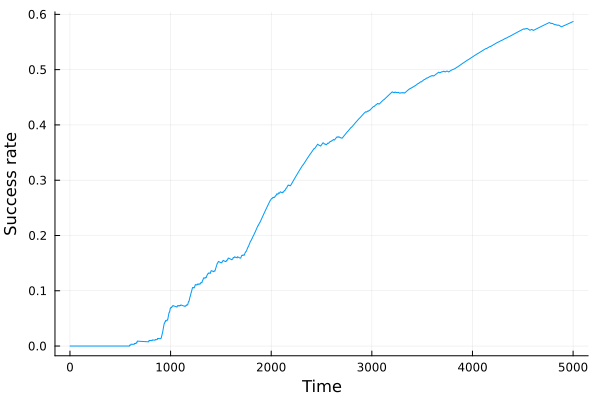

In [10]:
plot(success_rates, xlabel = "Time", ylabel = "Success rate", legend = false)

<b> Plot 2: </b> Value function surface.

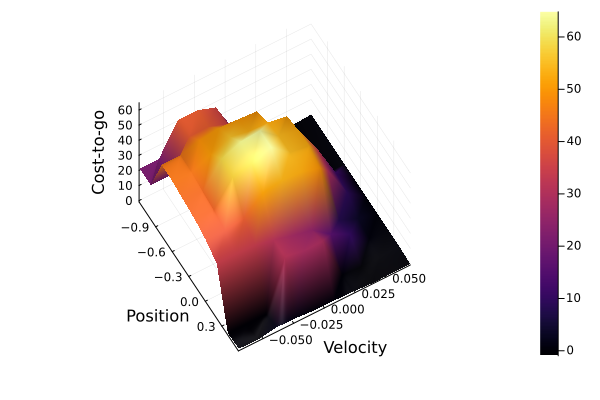

In [11]:
X = range(state_space(agent.env)[1].left,state_space(agent.env)[1].right,length = 10)
Y = range(state_space(agent.env)[2].left,state_space(agent.env)[2].right,length = 10)
Z = [maximum(agent.W * code((x,y),agent.tillings)) for x in X, y in Y];

plot(X,Y,-Z, st=:surface, camera = (60,60), xlabel = "Position", ylabel = "Velocity", zlabel = "Cost-to-go")

<b> Plot 3: </b> Successe rate as a function of time in validation mode.

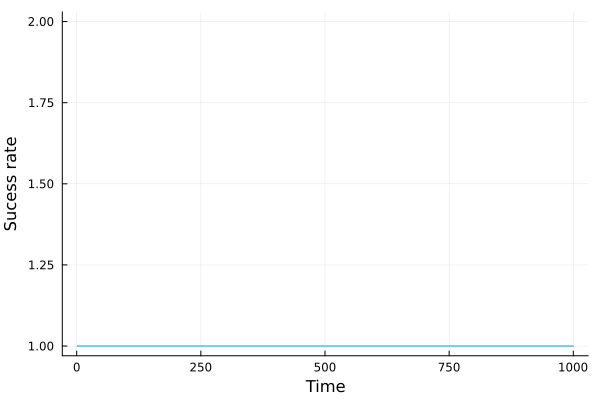

In [12]:
rewards,success_rates = run!(agent,1000; train = false, plotting = false, summary = false);
plot(success_rates, xlabel = "Time", ylabel = "Sucess rate", legend = false)